In [1]:
from google.colab import drive
import zipfile
import os

# Mount Google Drive
drive.mount('/content/drive')




Mounted at /content/drive


In [2]:
# Path to your zip file
zip_path = "/content/drive/MyDrive/wiki_small.zip"
extract_dir = "/content/wikiart_small"

# Unzip the file if not already done
if not os.path.exists(extract_dir):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Path to the wikiart dataset
source_dir = '/content/wikiart_small/wiki_small/'

# Define the target directories for training and validation
train_dir = '/content/wikiart_small/wiki_small/train'
val_dir = '/content/wikiart_small/wiki_small/val'

# Create train and val directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Loop through each style label to create directories and split the data
for style in STYLE_LABELS:
    # Path to the current style folder
    style_path = os.path.join(source_dir, style)

    # Check if the style folder exists
    if not os.path.exists(style_path):
        print(f"Skipping {style}: Directory does not exist.")
        continue

    # Create corresponding directories in train and val
    train_style_dir = os.path.join(train_dir, style)
    val_style_dir = os.path.join(val_dir, style)
    os.makedirs(train_style_dir, exist_ok=True)
    os.makedirs(val_style_dir, exist_ok=True)

    # Get all image files for the current style
    images = [img for img in os.listdir(style_path) if img.endswith(('jpg', 'jpeg', 'png'))]

    # Split images into train and val (80/20 split)
    train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

    # Move the images into the train and validation directories
    for img in train_images:
        shutil.move(os.path.join(style_path, img), os.path.join(train_style_dir, img))

    for img in val_images:
        shutil.move(os.path.join(style_path, img), os.path.join(val_style_dir, img))

print("Dataset has been split into train and val directories.")


Dataset has been split into train and val directories.


In [6]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# Define paths
base_dir = '/content/wikiart_small/wiki_small'
train_dir = os.path.join(base_dir, 'train')  # Make sure to separate your data into train/val folders
val_dir = os.path.join(base_dir, 'val')

# Define style labels
STYLE_LABELS = [
    'Abstract_Expressionism', 'Baroque', 'Cubism', 'Fauvism',
    'Mannerism_Late_Renaissance', 'Minimalism',
    'Naive_Art_Primitivism', 'Pop_Art', 'Post_Impressionism', 'Symbolism'
]

# Setup paths for saving model
checkpoint_path = '/content/drive/MyDrive/wikiart_model_checkpoints/'


In [7]:
# Define preprocessing and augmentation strategies
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Load the datasets from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # MobileNet input size
    batch_size=32,
    class_mode='categorical',  # For multi-class classification
    classes=STYLE_LABELS
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=STYLE_LABELS
)


Found 7904 images belonging to 10 classes.
Found 1980 images belonging to 10 classes.


In [8]:
# Load the MobileNetV2 model with pre-trained weights, excluding the top layer
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Build the full model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(STYLE_LABELS), activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Starting learning rate
              loss='categorical_crossentropy',  # Multi-class classification loss
              metrics=['accuracy'])


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Define callbacks
early_stopping = EarlyStopping(
    patience=5,  # Stop after 5 epochs if no improvement
    restore_best_weights=True,
    monitor='val_loss',  # Monitor validation loss
    verbose=1
)

checkpoint = ModelCheckpoint(
    checkpoint_path + 'best_model.keras',
    save_best_only=True,
    monitor='val_loss',
    verbose=1
)


In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=int(train_generator.samples // train_generator.batch_size),  # Convert to int
    epochs=50,
    validation_data=val_generator,
    validation_steps=int(val_generator.samples // val_generator.batch_size),  # Convert to int
    callbacks=[early_stopping, checkpoint]
)

# Define the path to save the model in .keras format
final_model_path = '/content/drive/MyDrive/final_wikiart_model.keras'

# Save the final model after training in .keras format
model.save(final_model_path)


Epoch 1/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 993ms/step - accuracy: 0.6274 - loss: 1.0743
Epoch 1: val_loss improved from inf to 1.08996, saving model to /content/drive/MyDrive/wikiart_model_checkpoints/best_model.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 302s 1s/step - accuracy: 0.6274 - loss: 1.0742 - val_accuracy: 0.6163 - val_loss: 1.0900
Epoch 2/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6573 - loss: 1.0001
Epoch 2: val_loss improved from 1.08996 to 1.02782, saving model to /content/drive/MyDrive/wikiart_model_checkpoints/best_model.keras
247/247 ━━━━━━━━━━━━━━━━━━━━ 316s 1s/step - accuracy: 0.6573 - loss: 1.0001 - val_accuracy: 0.6475 - val_loss: 1.0278
Epoch 3/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6621 - loss: 0.9742
Epoch 3: val_loss did not improve from 1.02782
247/247 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - accuracy: 0.6621 - loss: 0.9741 - val_accuracy: 0.6440 - val_loss: 1.0407
Epoch 4/50
247/247 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6708 - loss:

Model loaded.
Found 1980 images belonging to 10 classes.
62/62 ━━━━━━━━━━━━━━━━━━━━ 58s 884ms/step


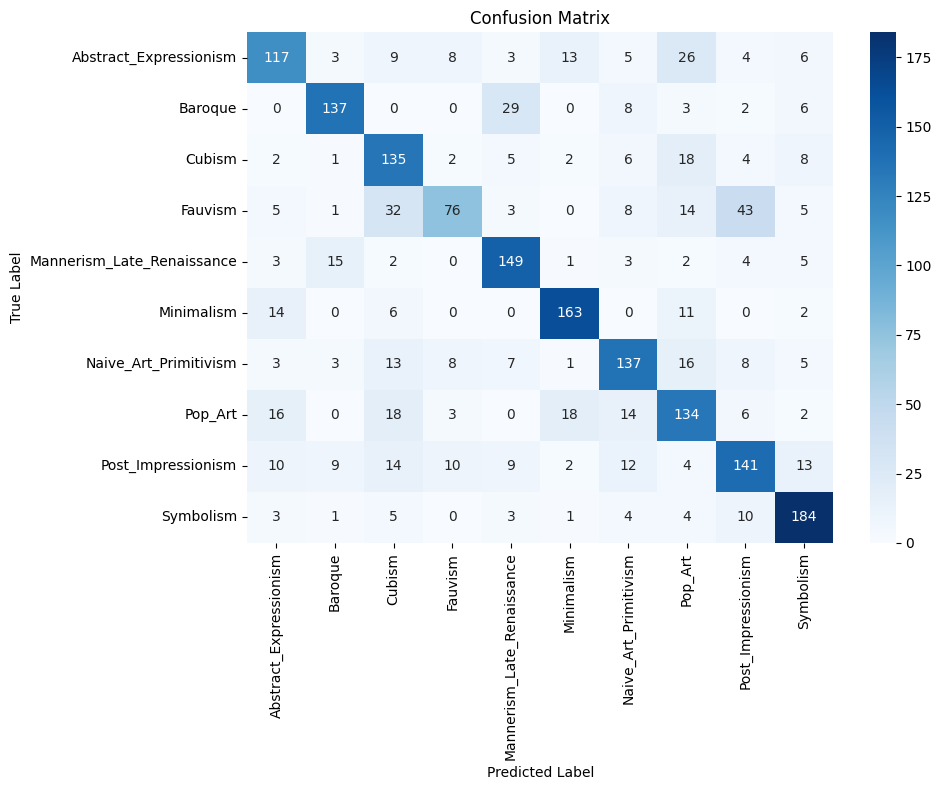

Classification Report:

                            precision    recall  f1-score   support

    Abstract_Expressionism       0.68      0.60      0.64       194
                   Baroque       0.81      0.74      0.77       185
                    Cubism       0.58      0.74      0.65       183
                   Fauvism       0.71      0.41      0.52       187
Mannerism_Late_Renaissance       0.72      0.81      0.76       184
                Minimalism       0.81      0.83      0.82       196
     Naive_Art_Primitivism       0.70      0.68      0.69       201
                   Pop_Art       0.58      0.64      0.60       211
        Post_Impressionism       0.64      0.63      0.63       224
                 Symbolism       0.78      0.86      0.82       215

                  accuracy                           0.69      1980
                 macro avg       0.70      0.69      0.69      1980
              weighted avg       0.70      0.69      0.69      1980



In [16]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set paths
model_path = '/content/drive/MyDrive/final_wikiart_model.keras'
val_dir = '/content/wikiart_small/wiki_small/val'
img_size = 224
batch_size = 32

# Step 1: Load the trained model
model = load_model(model_path)
print("Model loaded.")

# Step 2: Recreate validation generator
val_datagen = ImageDataGenerator(rescale=1./255)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Step 3: Predict
predictions = model.predict(val_generator, steps=int(np.ceil(val_generator.samples / batch_size)))

predicted_classes = np.argmax(predictions, axis=1)

# Step 4: Get true labels and class names
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Step 5: Confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Step 6: Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Step 7: Classification report
print("Classification Report:\n")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))
